In [1]:

import os
import cv2
import selectivesearch
import sys

sys.path.append("..")  # Go up one level, adjust as necessary

from module.utils import  parse_xml, prepare_proposals,get_proposals, calculate_iou, load_image, get_id,calc_recall, calc_abo
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
#import torch 
from torch.utils.data import Dataset

img_path = "../Potholes/annotated-images/"
anno_path = "../Potholes/annotated-images/"
# This does not scale. We should save annotation proposals in a file. 

image_count = 10

files = os.listdir(img_path)


image_paths = np.array(list(filter(lambda file: file.endswith(".jpg"), files)))
label_paths = np.array(list(filter(lambda file: file.endswith(".xml"), files)))

image_paths = sorted(image_paths, key=get_id)
label_paths = sorted(label_paths, key=get_id)


boxes = [parse_xml(anno_path + label_path) for label_path in label_paths[:image_count]]
images = [load_image(img_path + img) for img in image_paths[:image_count]]

IMAGE_WIDTH = 800
IMAGE_HEIGHT = 800

IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)


In [2]:
proposal_boxes, labels = prepare_proposals(
    img_path,
    anno_path,
    5000, 
    0.5,
    scale=5,
    sigma=0.6,
    min_size=200,
    image_shape=IMAGE_SIZE,
    count=10)

In [3]:
def visualize_image(image, boxes,labels, proposals=None, scale_x=1.0, scale_y=1.0):
    # Adjust ground truth boxes according to the scale
    
    # Convert color for display
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Draw ground truth boxes in blue
    for (xmin, ymin, xmax, ymax) in boxes:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    
    # Draw Selective Search proposals in green if provided
    if proposals is not None:
        for (x, y, w, h), label in zip(proposals,labels):
            # Adjust Selective Search boxes according to the scale
            x = x * scale_x
            y = y * scale_y
            w = w * scale_x
            h = h * scale_y

            x, y, w, h = int(x), int(y), int(w), int(h)
            if label == 1:
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)
            else:
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 1)
                
            # cv2.putText(image, (15, 15), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [4]:
count = 0
for li in labels:
    for lj in li:
        if lj == 1:
            count += 1
count / image_count

68.1

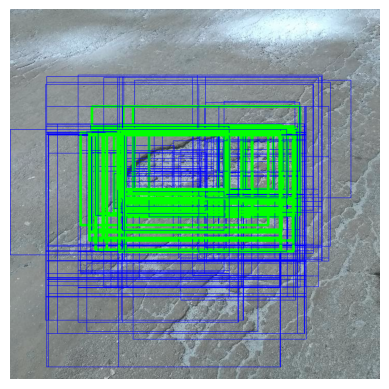

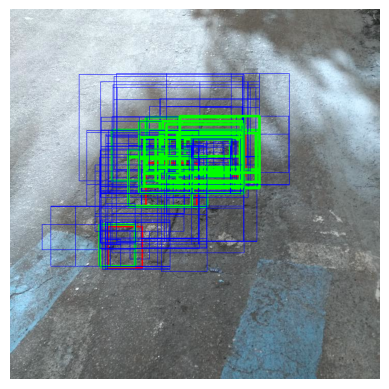

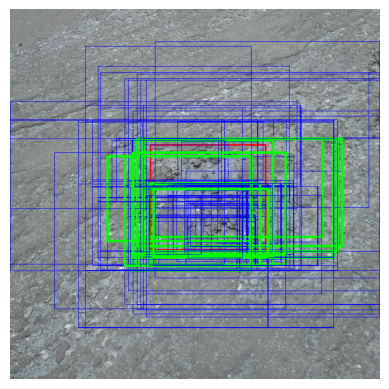

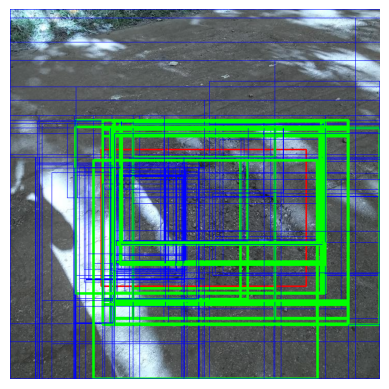

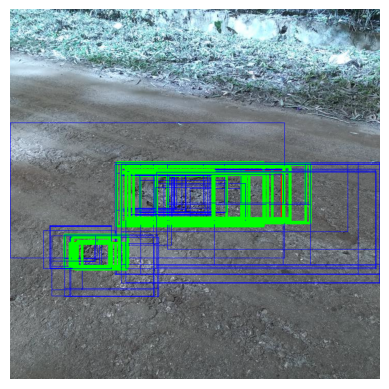

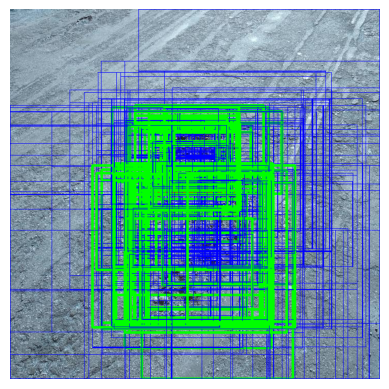

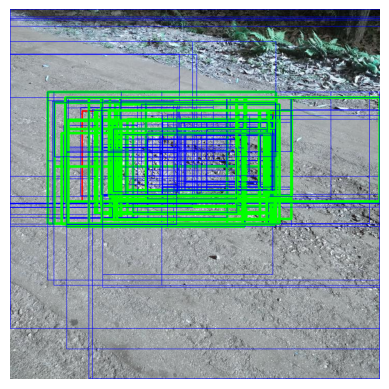

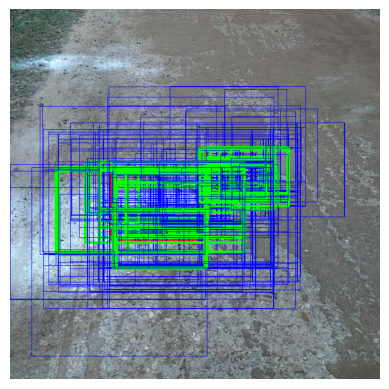

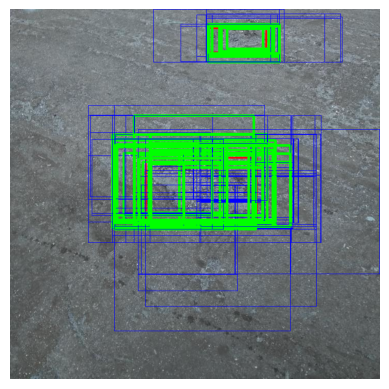

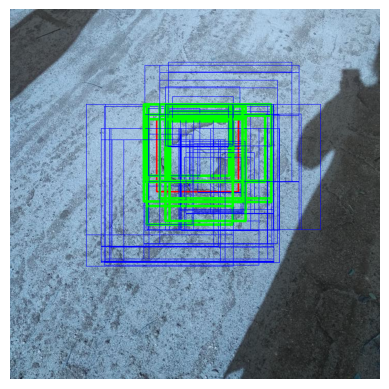

In [5]:

for i in range(image_count):
    # Calculate scale_x and scale_y
    scale_x = images[i].shape[1] / IMAGE_WIDTH
    scale_y = images[i].shape[0] / IMAGE_HEIGHT 


    visualize_image(images[i], boxes[i], labels[i], proposal_boxes[i], scale_x=scale_x, scale_y=scale_y)

In [ ]:
import xml.etree.ElementTree as ET
import os

def create_xml_from_proposals(image_filename, proposals, output_folder, images_path):
    # Create a new XML structure for the proposals
    root = ET.Element("annotation")
    folder = ET.SubElement(root, "folder")
    folder.text = "Proposals"

    filename_elem = ET.SubElement(root, "filename")
    filename_elem.text = image_filename

    size = ET.SubElement(root, "size")
    width_elem = ET.SubElement(size, "width")
    height_elem = ET.SubElement(size, "height")
    depth_elem = ET.SubElement(size, "depth")

    # Load the image to get its size
    image_path = os.path.join(images_path, image_filename)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return
    height, width, depth = image.shape

    height_elem.text = str(height)
    width_elem.text = str(width)
    depth_elem.text = str(depth)

    # Add the proposals as objects
    for idx, proposal in enumerate(proposals):
        object_elem = ET.SubElement(root, "object")
        name = ET.SubElement(object_elem, "name")
        name.text = "proposal"  # You can customize this name if needed

        bndbox = ET.SubElement(object_elem, "bndbox")
        xmin = ET.SubElement(bndbox, "xmin")
        ymin = ET.SubElement(bndbox, "ymin")
        xmax = ET.SubElement(bndbox, "xmax")
        ymax = ET.SubElement(bndbox, "ymax")

        xmin.text = str(int(proposal[0]))  # x1 coordinate
        ymin.text = str(int(proposal[1]))  # y1 coordinate
        xmax.text = str(int(proposal[2]))  # x2 coordinate
        ymax.text = str(int(proposal[3]))  # y2 coordinate

    # Save XML to output folder
    output_xml_path = os.path.join(output_folder, image_filename.replace(".jpg", "_proposals.xml").replace(".png", "_proposals.xml"))
    tree = ET.ElementTree(root)
    tree.write(output_xml_path)
    



In [ ]:
proposal_boxes, labels = prepare_proposals(
    img_path,
    anno_path,
    5000, 
    0.5,
    scale=5,
    sigma=0.6,
    min_size=200,
    image_shape=IMAGE_SIZE,
    count=len(image_paths))
output_folder = "SS_proposals_800x800/"

for i in range(len(image_paths)):
    image_filename = image_paths[i]
    create_xml_from_proposals(image_filename, proposal_boxes[i], output_folder, img_path)